In [17]:
#Imports and Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [18]:
#loading data and initial exploration
groundtruth_df = pd.read_csv('/content/drive/MyDrive/ISIC_2024_Training_GroundTruth.csv')
supplement_df = pd.read_csv('/content/drive/MyDrive/ISIC_2024_Training_Supplement.csv')
metadata_df = pd.read_csv('/content/drive/MyDrive/metadata.csv')

print(f"Ground truth data shape: {groundtruth_df.shape}")
print(f"Supplement (metadata) shape: {supplement_df.shape}")
print(f"Metadata shape: {metadata_df.shape}")

# Initial data investigation
print("\n" + "="*60)
print("TABLE 1: Initial Data Investigation")
print("="*60)
print(f"# of images in dataset: {len(supplement_df):,}")
print(f"# of features per image: {supplement_df.shape[1]}")
print(f"# of duplicate image ids: {supplement_df['isic_id'].duplicated().sum()}")


Ground truth data shape: (401059, 2)
Supplement (metadata) shape: (401059, 13)
Metadata shape: (401059, 42)

TABLE 1: Initial Data Investigation
# of images in dataset: 401,059
# of features per image: 13
# of duplicate image ids: 0


In [21]:
#data processing and missing values
#based on Pedro's inital EDA
print(f"\nsupplement columns:\n{supplement_df.columns}")


supplement columns:
Index(['isic_id', 'attribution', 'copyright_license', 'lesion_id', 'iddx_full',
       'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index',
       'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence'],
      dtype='object')


In [15]:
print(f"\ngroundtruth columns:\n{groundtruth_df.columns}")


groundtruth columns:
Index(['isic_id', 'malignant'], dtype='object')


In [19]:
print(f"\nmetadata columns:\n{metadata_df.columns}")


metadata columns:
Index(['isic_id', 'patient_id', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location',
       'tbp_lv_location_simple', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z'],
      dtype='object')


In [22]:
# Initial data investigation (recreating your Table 1)
print("\n" + "="*60)
print("TABLE 1: Initial Data Investigation")
print("="*60)
print(f"# of images in dataset: {len(metadata_df):,}")
print(f"# of features per image: {metadata_df.shape[1]}")
print(f"# of duplicate image ids: {metadata_df['isic_id'].duplicated().sum()}")

# Merge datasets - metadata has the rich clinical data we need
df = metadata_df.merge(groundtruth_df, on='isic_id', how='inner')
# Optionally merge supplement data too
df = df.merge(supplement_df, on='isic_id', how='inner')

print(f"% of images with ground truth results: {(len(df)/len(metadata_df))*100:.1f}%")
print(f"Avg. malignancy rate (from ground truth data): {df['malignant'].mean():.3f}")

print(f"\n✓ Total features after merging: {df.shape[1]}")
print(f"✓ Unique patients: {df['patient_id'].nunique():,}")
print(f"✓ Images per patient (avg): {len(df)/df['patient_id'].nunique():.1f}")


TABLE 1: Initial Data Investigation
# of images in dataset: 401,059
# of features per image: 42
# of duplicate image ids: 0
% of images with ground truth results: 100.0%
Avg. malignancy rate (from ground truth data): 0.001

✓ Total features after merging: 55
✓ Unique patients: 1,042
✓ Images per patient (avg): 384.9


In [24]:
# Missing values analysis
print("\n" + "="*50)
print("TABLE 2: Null/NaN Count")
print("="*50)
key_columns = ['sex', 'anatom_site_general', 'age_approx']
missing_data = {}

for col in key_columns:
    missing_count = df[col].isnull().sum()
    missing_pct = (missing_count / len(df)) * 100
    missing_data[col] = {'count': missing_count, 'percentage': missing_pct}
    print(f"{col}: {missing_count:,} ({missing_pct:.2f}% of original df)")

# Filter out rows with missing key values
df_clean = df.dropna(subset=key_columns).copy()
retention_rate = (len(df_clean) / len(df)) * 100
print(f"\nPost-filtering df size: {len(df_clean):,} ({retention_rate:.2f}% of original df)")

# Create binary encodings
df_clean['is_60_plus'] = (df_clean['age_approx'] >= 60).astype(int)
df_clean['is_head_neck'] = (df_clean['anatom_site_general'] == 'head/neck').astype(int)

print(f"Created is_60_plus feature: {df_clean['is_60_plus'].sum():,} patients ≥60 years")
print(f"Created is_head_neck feature: {df_clean['is_head_neck'].sum():,} head/neck lesions")


TABLE 2: Null/NaN Count
sex: 11,517 (2.87% of original df)
anatom_site_general: 5,756 (1.44% of original df)
age_approx: 2,798 (0.70% of original df)

Post-filtering df size: 381,914 (95.23% of original df)
Created is_60_plus feature: 201,756 patients ≥60 years
Created is_head_neck feature: 11,688 head/neck lesions


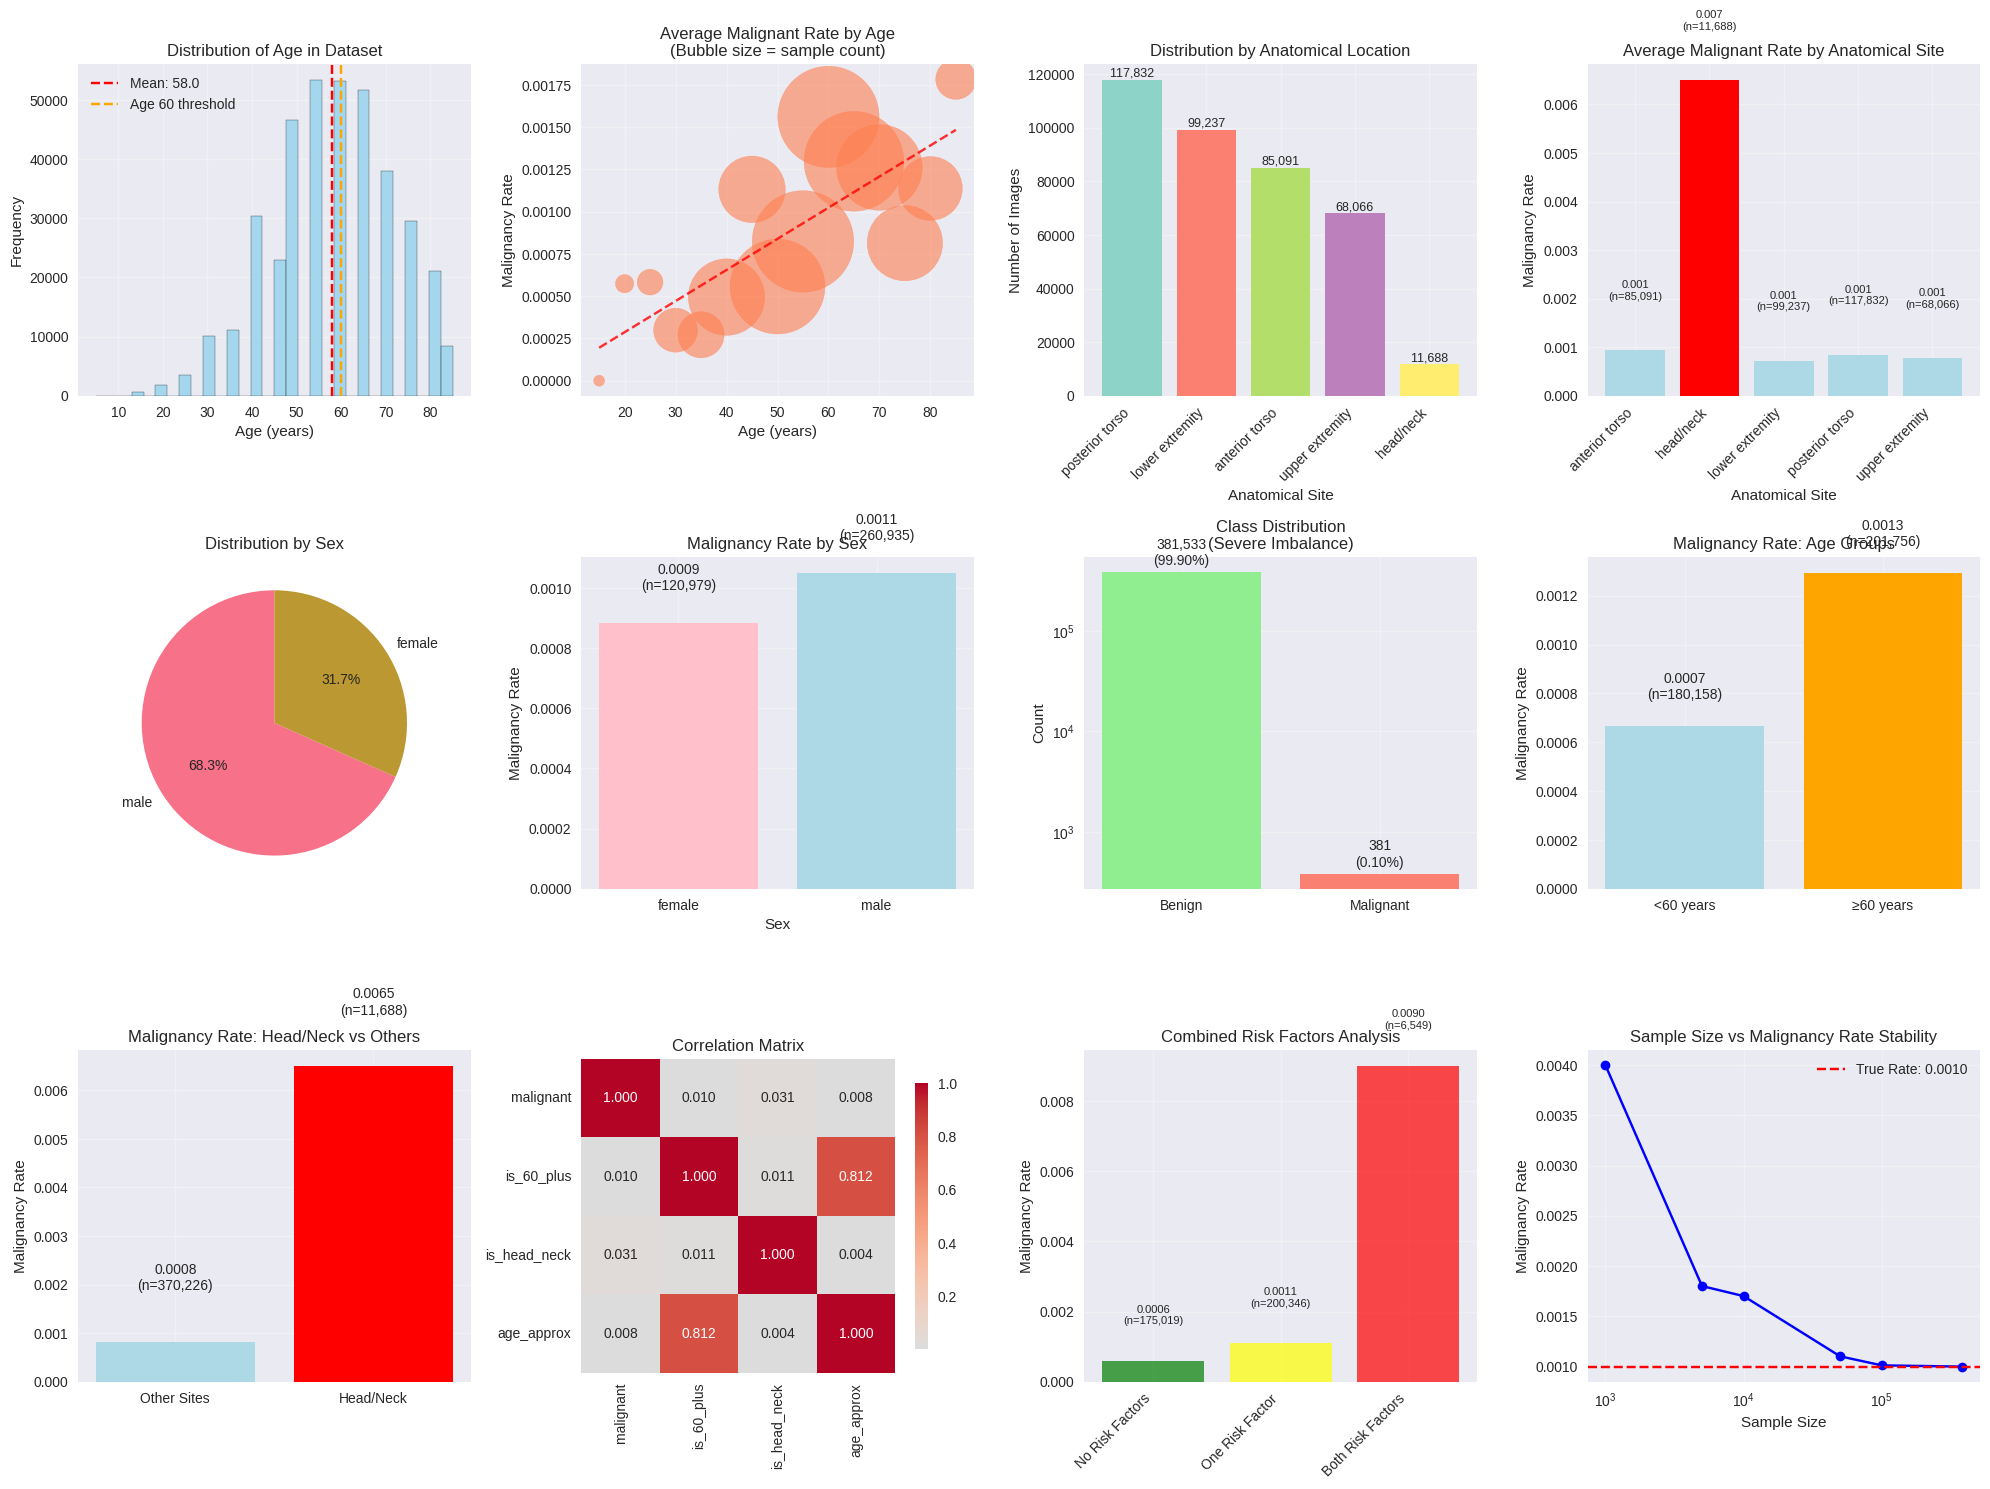

In [34]:

fig = plt.figure(figsize=(20, 15))

#Age Distribution Analysis
plt.subplot(3, 4, 1)
plt.hist(df_clean['age_approx'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(df_clean['age_approx'].mean(), color='red', linestyle='--',
           label=f'Mean: {df_clean["age_approx"].mean():.1f}')
plt.axvline(60, color='orange', linestyle='--', label='Age 60 threshold')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.title('Distribution of Age in Dataset')
plt.legend()
plt.grid(True, alpha=0.3)

#Age vs Malignancy Rate
plt.subplot(3, 4, 2)
age_malignancy = df_clean.groupby('age_approx')['malignant'].agg(['count', 'mean']).reset_index()
age_malignancy = age_malignancy[age_malignancy['count'] >= 10]  # Filter for statistical significance
plt.scatter(age_malignancy['age_approx'], age_malignancy['mean'],
           s=age_malignancy['count']/10, alpha=0.6, color='coral')
plt.xlabel('Age (years)')
plt.ylabel('Malignancy Rate')
plt.title('Average Malignant Rate by Age\n(Bubble size = sample count)')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(age_malignancy['age_approx'], age_malignancy['mean'], 1)
p = np.poly1d(z)
plt.plot(age_malignancy['age_approx'], p(age_malignancy['age_approx']), "r--", alpha=0.8)

#Anatomical Site Distribution
plt.subplot(3, 4, 3)
site_counts = df_clean['anatom_site_general'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(site_counts)))
bars = plt.bar(range(len(site_counts)), site_counts.values, color=colors)
plt.xlabel('Anatomical Site')
plt.ylabel('Number of Images')
plt.title('Distribution by Anatomical Location')
plt.xticks(range(len(site_counts)), site_counts.index, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, site_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{value:,}', ha='center', va='bottom', fontsize=9)

#Anatomical Site vs Malignancy Rate
plt.subplot(3, 4, 4)
site_malignancy = df_clean.groupby('anatom_site_general')['malignant'].agg(['count', 'mean', 'sum']).reset_index()
bars = plt.bar(range(len(site_malignancy)), site_malignancy['mean'],
               color=['red' if x == 'head/neck' else 'lightblue' for x in site_malignancy['anatom_site_general']])
plt.xlabel('Anatomical Site')
plt.ylabel('Malignancy Rate')
plt.title('Average Malignant Rate by Anatomical Site')
plt.xticks(range(len(site_malignancy)), site_malignancy['anatom_site_general'], rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add value labels
for i, (bar, rate, count) in enumerate(zip(bars, site_malignancy['mean'], site_malignancy['count'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{rate:.3f}\n(n={count:,})', ha='center', va='bottom', fontsize=8)

#Sex Distribution
plt.subplot(3, 4, 5)
sex_counts = df_clean['sex'].value_counts()
plt.pie(sex_counts.values, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution by Sex')

#Sex vs Malignancy Rate
plt.subplot(3, 4, 6)
sex_malignancy = df_clean.groupby('sex')['malignant'].agg(['count', 'mean']).reset_index()
bars = plt.bar(sex_malignancy['sex'], sex_malignancy['mean'], color=['pink', 'lightblue'])
plt.xlabel('Sex')
plt.ylabel('Malignancy Rate')
plt.title('Malignancy Rate by Sex')
plt.grid(True, alpha=0.3)

for bar, rate, count in zip(bars, sex_malignancy['mean'], sex_malignancy['count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
             f'{rate:.4f}\n(n={count:,})', ha='center', va='bottom')

#Class Imbalance Visualization
plt.subplot(3, 4, 7)
malignancy_counts = df_clean['malignant'].value_counts()
colors = ['lightgreen', 'salmon']
bars = plt.bar(['Benign', 'Malignant'], malignancy_counts.values, color=colors)
plt.ylabel('Count')
plt.title('Class Distribution\n(Severe Imbalance)')
plt.yscale('log')  # Log scale to better show the imbalance
plt.grid(True, alpha=0.3)

for bar, count in zip(bars, malignancy_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1,
             f'{count:,}\n({count/len(df_clean)*100:.2f}%)', ha='center', va='bottom')

#Age Group Analysis (60+ vs <60)
plt.subplot(3, 4, 8)
age_group_malignancy = df_clean.groupby('is_60_plus')['malignant'].agg(['count', 'mean']).reset_index()
age_labels = ['<60 years', '≥60 years']
bars = plt.bar(age_labels, age_group_malignancy['mean'], color=['lightblue', 'orange'])
plt.ylabel('Malignancy Rate')
plt.title('Malignancy Rate: Age Groups')
plt.grid(True, alpha=0.3)

for i, (bar, rate, count) in enumerate(zip(bars, age_group_malignancy['mean'], age_group_malignancy['count'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
             f'{rate:.4f}\n(n={count:,})', ha='center', va='bottom')

#Head/Neck vs Other Sites
plt.subplot(3, 4, 9)
site_group_malignancy = df_clean.groupby('is_head_neck')['malignant'].agg(['count', 'mean']).reset_index()
site_labels = ['Other Sites', 'Head/Neck']
bars = plt.bar(site_labels, site_group_malignancy['mean'], color=['lightblue', 'red'])
plt.ylabel('Malignancy Rate')
plt.title('Malignancy Rate: Head/Neck vs Others')
plt.grid(True, alpha=0.3)

for i, (bar, rate, count) in enumerate(zip(bars, site_group_malignancy['mean'], site_group_malignancy['count'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{rate:.4f}\n(n={count:,})', ha='center', va='bottom')

#Correlation Matrix of Key Variables
plt.subplot(3, 4, 10)
corr_vars = ['malignant', 'is_60_plus', 'is_head_neck', 'age_approx']
corr_matrix = df_clean[corr_vars].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix')

#Combined Risk Factors
plt.subplot(3, 4, 11)
df_clean['risk_score'] = df_clean['is_60_plus'] + df_clean['is_head_neck']
risk_malignancy = df_clean.groupby('risk_score')['malignant'].agg(['count', 'mean']).reset_index()
risk_labels = ['No Risk Factors', 'One Risk Factor', 'Both Risk Factors']
bars = plt.bar(risk_labels, risk_malignancy['mean'],
               color=['green', 'yellow', 'red'], alpha=0.7)
plt.ylabel('Malignancy Rate')
plt.title('Combined Risk Factors Analysis')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

for bar, rate, count in zip(bars, risk_malignancy['mean'], risk_malignancy['count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{rate:.4f}\n(n={count:,})', ha='center', va='bottom', fontsize=8)

#Sample Size Adequacy Check
plt.subplot(3, 4, 12)
sample_sizes = [1000, 5000, 10000, 50000, 100000, len(df_clean)]
malignancy_rates = []
for size in sample_sizes:
    if size <= len(df_clean):
        sample = df_clean.sample(n=size, random_state=42)
        malignancy_rates.append(sample['malignant'].mean())
    else:
        malignancy_rates.append(np.nan)

plt.plot([s for s, r in zip(sample_sizes, malignancy_rates) if not np.isnan(r)],
         [r for r in malignancy_rates if not np.isnan(r)], 'bo-')
plt.axhline(df_clean['malignant'].mean(), color='red', linestyle='--',
           label=f'True Rate: {df_clean["malignant"].mean():.4f}')
plt.xlabel('Sample Size')
plt.ylabel('Malignancy Rate')
plt.title('Sample Size vs Malignancy Rate Stability')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [35]:
# Print comprehensive statistics
print("\n" + "="*60)
print("COMPREHENSIVE EDA SUMMARY")
print("="*60)

print(f"\nDataset Overview:")
print(f"   • Total samples after cleaning: {len(df_clean):,}")
print(f"   • Malignancy rate: {df_clean['malignant'].mean():.4f} ({df_clean['malignant'].sum():,} malignant cases)")
print(f"   • Class imbalance ratio: {(1-df_clean['malignant'].mean())/df_clean['malignant'].mean():.1f}:1 (benign:malignant)")

print(f"\n Demographics:")
print(f"   • Age range: {df_clean['age_approx'].min():.0f}-{df_clean['age_approx'].max():.0f} years")
print(f"   • Mean age: {df_clean['age_approx'].mean():.1f} ± {df_clean['age_approx'].std():.1f} years")
print(f"   • Patients ≥60: {df_clean['is_60_plus'].sum():,} ({df_clean['is_60_plus'].mean()*100:.1f}%)")
print(f"   • Sex distribution: {dict(df_clean['sex'].value_counts())}")

print(f"\n Anatomical Distribution:")
for site, count in df_clean['anatom_site_general'].value_counts().items():
    pct = count/len(df_clean)*100
    malignancy = df_clean[df_clean['anatom_site_general']==site]['malignant'].mean()
    print(f"   • {site}: {count:,} ({pct:.1f}%) - Malignancy rate: {malignancy:.4f}")

print(f"\n Risk Factor Analysis:")
age_60_malignancy = df_clean[df_clean['is_60_plus']==1]['malignant'].mean()
head_neck_malignancy = df_clean[df_clean['is_head_neck']==1]['malignant'].mean()
print(f"   • Age ≥60 malignancy rate: {age_60_malignancy:.4f}")
print(f"   • Head/neck malignancy rate: {head_neck_malignancy:.4f}")
print(f"   • Head/neck risk elevation: {head_neck_malignancy/df_clean['malignant'].mean():.1f}x higher")


COMPREHENSIVE EDA SUMMARY

Dataset Overview:
   • Total samples after cleaning: 381,914
   • Malignancy rate: 0.0010 (381.0 malignant cases)
   • Class imbalance ratio: 1001.4:1 (benign:malignant)

 Demographics:
   • Age range: 5-85 years
   • Mean age: 58.0 ± 13.7 years
   • Patients ≥60: 201,756 (52.8%)
   • Sex distribution: {'male': np.int64(260935), 'female': np.int64(120979)}

 Anatomical Distribution:
   • posterior torso: 117,832 (30.9%) - Malignancy rate: 0.0008
   • lower extremity: 99,237 (26.0%) - Malignancy rate: 0.0007
   • anterior torso: 85,091 (22.3%) - Malignancy rate: 0.0009
   • upper extremity: 68,066 (17.8%) - Malignancy rate: 0.0008
   • head/neck: 11,688 (3.1%) - Malignancy rate: 0.0065

 Risk Factor Analysis:
   • Age ≥60 malignancy rate: 0.0013
   • Head/neck malignancy rate: 0.0065
   • Head/neck risk elevation: 6.5x higher


In [36]:
#AlexNet Architecture

def create_alexnet_model(input_shape=(224, 224, 3), num_classes=1):

    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # First Convolutional Block
        # Conv1: 96 filters, 11x11 kernel, stride 4
        layers.Conv2D(96, (11, 11), strides=4, activation='relu', padding='valid'),
        layers.BatchNormalization(),  # Modern replacement for LRN
        layers.MaxPooling2D((3, 3), strides=2),

        # Second Convolutional Block
        # Conv2: 256 filters, 5x5 kernel
        layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=2),

        # Third Convolutional Block
        # Conv3: 384 filters, 3x3 kernel
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),

        # Fourth Convolutional Block
        # Conv4: 384 filters, 3x3 kernel
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),

        # Fifth Convolutional Block
        # Conv5: 256 filters, 3x3 kernel
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((3, 3), strides=2),

        # Flatten for fully connected layers
        layers.Flatten(),

        # First Fully Connected Layer
        # FC1: 4096 neurons
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        # Second Fully Connected Layer
        # FC2: 4096 neurons
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        # Output Layer
        # Binary classification for malignant/benign
        layers.Dense(num_classes, activation='sigmoid')
    ])

    return model

# AlexNet model
alexnet_model = create_alexnet_model()

# Compile with appropriate loss function for imbalanced data
alexnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Display model architecture
print("\nAlexNet Architecture Summary:")
alexnet_model.summary()

# Calculate model parameters
total_params = alexnet_model.count_params()
print(f"\n AlexNet Model Statistics:")
print(f"   • Total parameters: {total_params:,}")
print(f"   • Model size: ~{total_params*4/(1024**2):.1f} MB (32-bit floats)")


AlexNet Architecture Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,752,513 (178.35 MB)

 Trainable params: 46,751,809 (178.34 MB)

 Non-trainable params: 704 (2.75 KB)


 AlexNet Model Statistics:
   • Total parameters: 46,752,513
   • Model size: ~178.3 MB (32-bit floats)


In [37]:
#data prep

# Sample a subset
SAMPLE_SIZE = 50000
df_sample = df_clean.sample(n=min(SAMPLE_SIZE, len(df_clean)), random_state=42)

print(f"Using sample size: {len(df_sample):,} images")
print(f"Sample malignancy rate: {df_sample['malignant'].mean():.4f}")

# Calculate class weights for imbalanced data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_sample['malignant']),
    y=df_sample['malignant']
)
class_weight_dict = dict(zip([0, 1], class_weights))
print(f"Class weights: {class_weight_dict}")

# Prepare metadata features
X_metadata = df_sample[['is_60_plus', 'is_head_neck']].values.astype(np.float32)
y = df_sample['malignant'].values

# Split the data
X_meta_train, X_meta_test, y_train, y_test = train_test_split(
    X_metadata, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_meta_train):,} samples")
print(f"Test set: {len(X_meta_test):,} samples")
print(f"Training malignancy rate: {y_train.mean():.4f}")
print(f"Test malignancy rate: {y_test.mean():.4f}")

Using sample size: 50,000 images
Sample malignancy rate: 0.0011
Class weights: {0: np.float64(0.5005506056662329), 1: np.float64(454.54545454545456)}
Training set: 40,000 samples
Test set: 10,000 samples
Training malignancy rate: 0.0011
Test malignancy rate: 0.0011


In [38]:


def create_image_data_generator(df_subset, image_dir, batch_size=32, target_size=(224, 224)):

    def data_generator():
        while True:
            # Shuffle the dataframe
            df_shuffled = df_subset.sample(frac=1, random_state=np.random.randint(0, 10000))

            for i in range(0, len(df_shuffled), batch_size):
                batch_df = df_shuffled.iloc[i:i+batch_size]

                images = []
                labels = []

                for _, row in batch_df.iterrows():
                    # Load and preprocess image
                    image_path = os.path.join(image_dir, f"{row['isic_id']}.jpg")

                    try:
                        # Load image
                        image = tf.io.read_file(image_path)
                        image = tf.image.decode_jpeg(image, channels=3)
                        image = tf.image.resize(image, target_size)
                        image = tf.cast(image, tf.float32) / 255.0

                        # Data augmentation for training
                        if np.random.random() > 0.5:  # Random horizontal flip
                            image = tf.image.flip_left_right(image)
                        if np.random.random() > 0.5:  # Random rotation
                            image = tf.image.rot90(image, k=np.random.randint(0, 4))

                        images.append(image.numpy())
                        labels.append(row['malignant'])

                    except Exception as e:
                        print(f"Error loading image {row['isic_id']}: {e}")
                        continue

                if len(images) > 0:
                    yield np.array(images), np.array(labels)

    return data_generator

In [39]:
#training baseline

baseline_model = models.Sequential([
    layers.Input(shape=(2,)),  # is_60_plus, is_head_neck
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Train baseline model
print("Training baseline model...")
baseline_history = baseline_model.fit(
    X_meta_train, y_train,
    validation_data=(X_meta_test, y_test),
    epochs=20,
    batch_size=128,
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluate baseline
baseline_pred_probs = baseline_model.predict(X_meta_test)
baseline_predictions = (baseline_pred_probs >= 0.5).astype(int).flatten()

print(f"\n Baseline Model Results:")
print("="*40)
print(classification_report(y_test, baseline_predictions,
                          target_names=['Benign', 'Malignant']))

baseline_auc = roc_auc_score(y_test, baseline_pred_probs)
print(f"AUC-ROC: {baseline_auc:.4f}")

Training baseline model...
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7133 - loss: 0.7218 - precision: 0.0013 - recall: 0.3493 - val_accuracy: 0.9831 - val_loss: 0.5921 - val_precision: 0.0241 - val_recall: 0.3636
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6249 - loss: 0.8212 - precision: 6.7638e-04 - recall: 0.2359 - val_accuracy: 0.4717 - val_loss: 0.6112 - val_precision: 0.0017 - val_recall: 0.8182
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5331 - loss: 0.8127 - precision: 0.0015 - recall: 0.5480 - val_accuracy: 0.4717 - val_loss: 0.6685 - val_precision: 0.0017 - val_recall: 0.8182
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4916 - loss: 0.8781 - precision: 8.9853e-04 - recall: 0.3998 - val_accuracy: 0.9831 - val_loss: 0.6081 - val_precision: 0.0241 - val_recall: 0.3636
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5311 - loss: 0.7599 - precision: 0.0013 - recall: 0.4592 - 